In [1]:
import tensorflow as tf
import io
import re
import random
import collections
import codecs
import time
import numpy as np
import os
import unicodedata
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn.model_selection import train_test_split

## 构建数据集

In [2]:
def preprocess_sentence(line):
    line = ' '.join(re.split(' |\t|\v|\n',line))        
    line = re.split('([: ,.(){}\[\]=])',line)        
    line = list(filter(lambda x: x!=' 'and x!='',line))
    
    new_line = '<start> ' + ' '.join(line) + ' <end>'
    return new_line

In [3]:
def create_dataset(path,num_examples,rand_max=15,duplicate=2):
    input_data = []
    output_data = []
    
    lines = io.open(path,encoding='utf-8').read().strip().split('\n')
    if num_examples == None:
        num_examples = len(lines)

    for i in range(0,num_examples):
        
        rand_nums = set(random.randint(1,rand_max) for _ in range(duplicate))
        for rand_num in rand_nums:
            data = ''
            for j in range(i - rand_num,i):
                line = preprocess_sentence(lines[j].strip()) + ' '
                data += line
            input_data.append(data.strip())
            output_data.append(preprocess_sentence(lines[i].strip()))
        
    return input_data,output_data

In [4]:
path = "01-data/1_final_data_0219.py"
input_data,output_data = create_dataset(path,2)

In [129]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def get_num_words(lang):
    #获取词典大小,暂时用之前训的模型
    #lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',lower=False)
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    num_words = int(len(lang_tokenizer.word_index))
    return num_words
    
def tokenize(lang):
    num_words = get_num_words(lang)
#     lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words,
#                                                            oov_token='<unk>',filters='',lower=False)
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words,
                                                           oov_token='<unk>',filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
    
    return tensor, lang_tokenizer

def load_dataset(path,num_examples=None):
    inp_lang,targ_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [130]:
# 尝试实验不同大小的数据集
num_examples = None
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path, num_examples)

# 计算目标张量的最大长度 （max_length）
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [131]:
len(inp_lang.word_index)

11567

In [133]:
"""目前先不采用"""
# 采用 90 - 10 的比例切分训练集和验证集
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.01)

# 显示长度
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

74660 74660 755 755


## 创建一个tf.data的数据集

In [134]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 128
units = 256
input_vocab_size = len(inp_lang.word_index)+1
target_vocab_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [135]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch, example_target_batch

(<tf.Tensor: shape=(64, 606), dtype=int32, numpy=
 array([[   2,  199,    4, ...,    0,    0,    0],
        [   2,   16,   12, ...,    0,    0,    0],
        [   2,   23,  133, ...,    0,    0,    0],
        ...,
        [   2,  370,    8, ...,    0,    0,    0],
        [   2, 4073,    5, ...,    0,    0,    0],
        [   2,   26,   13, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: shape=(64, 245), dtype=int32, numpy=
 array([[    2,    16,   117, ...,     0,     0,     0],
        [    2,    14, 10326, ...,     0,     0,     0],
        [    2,   879,     4, ...,     0,     0,     0],
        ...,
        [    2,    13,     5, ...,     0,     0,     0],
        [    2,    16,    13, ...,     0,     0,     0],
        [    2,    14,  2909, ...,     0,     0,     0]], dtype=int32)>)

## 位置编码（Positional encoding）

In [12]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [13]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # 将 sin 应用于数组中的偶数索引（indices）；2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


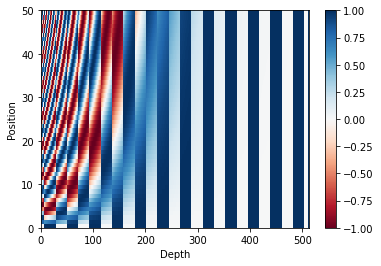

In [14]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 遮挡（Masking）

In [15]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # 添加额外的维度来将填充加到
    # 注意力对数（logits）。
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [16]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

## 按比缩放的点积注意力（Scaled dot product attention）

In [17]:
def scaled_dot_product_attention(q, k, v, mask):
    """计算注意力权重。
    q, k, v 必须具有匹配的前置维度。
    k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
    虽然 mask 根据其类型（填充或前瞻）有不同的形状，
    但是 mask 必须能进行广播转换以便求和。

    参数:
    q: 请求的形状 == (..., seq_len_q, depth)
    k: 主键的形状 == (..., seq_len_k, depth)
    v: 数值的形状 == (..., seq_len_v, depth_v)
    mask: Float 张量，其形状能转换成
          (..., seq_len_q, seq_len_k)。默认为None。

    返回值:
    输出，注意力权重
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # 缩放 matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 将 mask 加入到缩放的张量上。
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax 在最后一个轴（seq_len_k）上归一化，因此分数
    # 相加等于1。
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [18]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

## 多头注意力（Multi-head attention）

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """分拆最后一个维度到 (num_heads, depth).
        转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

## 点式前馈网络（Point wise feed forward network）

In [20]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

## 编码与解码（Encoder and decoder）

In [21]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

## 解码器层（Decoder layer）

In [22]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

## 编码器（Encoder）

In [23]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # 将嵌入和位置编码相加。
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

## 解码器（Decoder）

In [24]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

## 创建 Transformer

In [25]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

## 配置超参数（hyperparameters）

In [26]:
num_layers = 6
d_model = 256
dff = 512
num_heads = 8
dropout_rate = 0.1

## 优化器（Optimizer）

In [27]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [28]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

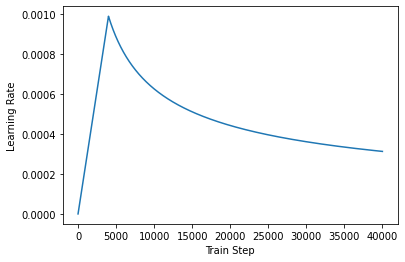

In [29]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 损失函数与指标（Loss and metrics）

In [30]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [31]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [32]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## 训练与检查点（Training and checkpointing）

In [33]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [34]:
def create_masks(inp, tar):
    # 编码器填充遮挡
    enc_padding_mask = create_padding_mask(inp)

    # 在解码器的第二个注意力模块使用。
    # 该填充遮挡用于遮挡编码器的输出。
    dec_padding_mask = create_padding_mask(inp)

    # 在解码器的第一个注意力模块使用。
    # 用于填充（pad）和遮挡（mask）解码器获取到的输入的后续标记（future tokens）。
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [35]:
checkpoint_path = "03-checkpoints/03-0402_01"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [36]:
# 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
# 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
# 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
# 更多的通用形状。

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [38]:
EPOCHS = 30
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.3642 Accuracy 0.0000
Epoch 1 Batch 50 Loss 0.3831 Accuracy 0.0010
Epoch 1 Batch 100 Loss 0.3719 Accuracy 0.0025
Epoch 1 Batch 150 Loss 0.3619 Accuracy 0.0030
Epoch 1 Batch 200 Loss 0.3499 Accuracy 0.0032
Epoch 1 Batch 250 Loss 0.3364 Accuracy 0.0034
Epoch 1 Batch 300 Loss 0.3215 Accuracy 0.0042
Epoch 1 Batch 350 Loss 0.3057 Accuracy 0.0054
Epoch 1 Batch 400 Loss 0.2905 Accuracy 0.0066
Epoch 1 Batch 450 Loss 0.2772 Accuracy 0.0078
Epoch 1 Batch 500 Loss 0.2651 Accuracy 0.0088
Epoch 1 Batch 550 Loss 0.2540 Accuracy 0.0098
Epoch 1 Batch 600 Loss 0.2443 Accuracy 0.0107
Epoch 1 Batch 650 Loss 0.2358 Accuracy 0.0115
Epoch 1 Batch 700 Loss 0.2279 Accuracy 0.0121
Epoch 1 Batch 750 Loss 0.2210 Accuracy 0.0128
Epoch 1 Batch 800 Loss 0.2148 Accuracy 0.0133
Epoch 1 Batch 850 Loss 0.2089 Accuracy 0.0138
Epoch 1 Batch 900 Loss 0.2036 Accuracy 0.0143
Epoch 1 Batch 950 Loss 0.1989 Accuracy 0.0148
Epoch 1 Batch 1000 Loss 0.1944 Accuracy 0.0152
Epoch 1 Batch 1150 Loss 0.1831 Accur

KeyboardInterrupt: 

## 评估（Evaluate）

In [136]:
def preprocess_eval_sentence(lines): 
    res = ""
    for line in lines:
        line = re.split('([: ,.(){}\[\]=])',line)        
        line = list(filter(lambda x: x!=' 'and x!='',line))

        res += '<start> ' + ' '.join(line) + ' <end> '
    return res.strip()

In [173]:
def evaluate(inp_sentence,max_len):
    inp_sentence = preprocess_eval_sentence(inp_sentence)
    inp_sentence = [inp_lang.word_index.get(word.lower(),inp_lang.word_index['<unk>']) for word in inp_sentence.split(' ')]
#     inp_sentence = tf.keras.preprocessing.sequence.pad_sequences([inp_sentence],
#                                                            maxlen=max_length_inp,
#                                                            padding='post')
    print(inp_sentence)
    inp_sentence = tf.convert_to_tensor(inp_sentence)
    encoder_input = tf.expand_dims(inp_sentence, 0)

    decoder_input = [targ_lang.word_index['<start>']]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_len):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # 从 seq_len 维度选择最后一个词
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
#         print("predicted_id: ")
#         print(predicted_id)
#         print("output: ")
#         print(output)
        
        # 如果 predicted_id 等于结束标记，就返回结果
        if predicted_id == targ_lang.word_index['<end>']:
            return inp_sentence,tf.squeeze(output, axis=0), attention_weights

        # 连接 predicted_id 与输出，作为解码器的输入传递到解码器。
        output = tf.concat([output, predicted_id], axis=-1)

    return inp_sentence,tf.squeeze(output, axis=0), attention_weights

In [174]:
def plot_attention_weights(encoder_input,attention, result, layer):
    fig = plt.figure(figsize=(16, 8))

    #sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # 画出注意力权重
        ax.matshow(attention[head][:, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(encoder_input)))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-0.5, -0.5)

        ax.set_xticklabels(
            [inp_lang.index_word[id.numpy()] for id in encoder_input], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([targ_lang.index_word[id.numpy()] for id in result], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))

    plt.tight_layout()
    plt.show()

In [175]:
def translate(sentence, max_len, plot=''):
    encoder_input,result, attention_weights = evaluate(sentence,max_len)

    predicted_sentence = ""
    for id in result[1:]:
        predicted_sentence += targ_lang.index_word[id.numpy()] + " " 

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(encoder_input,attention_weights, result, plot)

## beam search

In [168]:
def evaluate(inp_sentence,beam_nums,max_len):
    
    k = beam_nums = 4
    
    inp_sentence = preprocess_eval_sentence(inp_sentence)
    inp_sentence = [inp_lang.word_index.get(word.lower(),inp_lang.word_index['<unk>']) for word in inp_sentence.split(' ')]

    inp_sentence = tf.convert_to_tensor(inp_sentence)
    encoder_input = tf.expand_dims(inp_sentence, 0)
    decoder_input = [targ_lang.word_index['<start>']]
    output = tf.expand_dims(decoder_input, 0)
    
    #开始预测
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # 从 seq_len 维度选择最后一个词
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
    pre_probs,pre_ids = tf.nn.top_k(predictions[0],k)
    pre_probs = tf.nn.softmax(pre_probs)
    
    #将<start>加入到ids开头
    ids = tf.fill((1,k),targ_lang.word_index['<start>'])
    k_ids = tf.stack([ids,pre_ids],axis=2)
    
    #构造中间结果ids、probs
    res_ids = tf.squeeze(k_ids).numpy().tolist()
    res_probs = tf.squeeze(pre_probs).numpy().tolist()
    
    result_ids = []
    result_probs = []
    
    for step in range(max_len):
        
        mid_k_probs = []
        mid_k_ids = []
        
        for i in range(k):
            pre_prob = res_probs[i]
            pre_id = res_ids[i]
    
            #预测之前，需要将output抽取出来
            output = tf.expand_dims(pre_id, 0)
            predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
            predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
            
            next_k_scores, next_k_ids = tf.nn.top_k(predictions[0],k)
            next_k_scores = tf.nn.softmax(next_k_scores)
            next_k_scores *= pre_prob
            
            #将新的预测结果加到中间结果里去
            for j in range(k):
                mid_k_ids.append(pre_id + [next_k_ids[0][j].numpy()])
            
            #将probs加入到中间数组中
            mid_k_probs.extend(next_k_scores.numpy()[0].tolist())
        
        #一轮预测后，整理中间结果
        mid_k_probs = {index:prob for index,prob in enumerate(mid_k_probs)}
        mid_k_probs = sorted(mid_k_probs.items(), key=lambda x: x[1],reverse=True)
        
        res_ids = []
        res_probs = []
        for i in range(k):
            res_id = mid_k_ids[mid_k_probs[i][0]]
            res_prob = mid_k_probs[i][1]
            
            if res_id[-1] == targ_lang.word_index['<end>']:
                result_ids.append(res_id)
                result_probs.append(res_prob)
                k -= 1
            else:
                res_ids.append(res_id)
                res_probs.append(res_prob)
        
        if k < 1:
            #返回结果
#             print("result_ids: ")
#             print(result_ids)
#             print("result_probs: ")
#             print(result_probs)
            return result_ids,result_probs

#     print("beam_result: ")
#     print(beam_result)
    return result_ids,result_probs

In [169]:
def test_evaluate(sentence,beam_nums,max_len):
    result_ids,result_probs = evaluate(sentence,beam_nums,max_len)
    
    predicted_sentences = []
    for i in range(len(result_ids)):
        res = ""
        for id in result_ids[i][1:-1]:
            res += targ_lang.index_word[id] + " " 
        predicted_sentences.append([res.strip(),result_probs[i]])
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentences))

In [ ]:
max_len = 50
beam_nums = 4
sentence = [""]
test_evaluate(sentence,beam_nums,max_len)